<a href="https://colab.research.google.com/github/130ndim/dul_2021/blob/hw11/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
# Supports training classifier on gpu
!git clone --branch hw11 https://github.com/130ndim/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 533 (delta 194), reused 155 (delta 100), pack-reused 194
Receiving objects: 100% (533/533), 63.31 MiB | 20.34 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26969 sha256=2cd75556ab07a3c9897a9bd96f26abb7b5ffc14cb88fbae247c4754c0f1d2092
  Stored in directory: /tmp/pip-ephem-wheel-cache-igxs2hqx/wheels/55/59/29/0fb1c63565

In [24]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data

import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu
import numpy as np

from dul_2021.utils.hw11_utils import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [25]:
class ConvNet(nn.Module):
    def __init__(self, in_dim=1, out_dim=128):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_dim, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, out_dim),
        )

    def forward(self, x):
        return self.seq(x)

In [26]:
def _identity(x): return x

class SSDatasetWrapper(data.Dataset):
    def __init__(self, base, transform=_identity):
        self._base = base
        self._transform = transform

    def __getitem__(self, idx):
        orig_data, _ = self._base[idx]
        return self._transform(orig_data), self._transform(orig_data)

    def __len__(self):
        return len(self._base)

In [27]:
class BYOL(nn.Module):
    def __init__(self, id_=1, od=128, gamma=0.99):
        super().__init__()
        self._gamma = gamma

        self.student = ConvNet(id_, od)

        self.teacher = ConvNet(id_, od)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

        self.predictor = nn.Sequential(
            nn.Linear(od, 2 * od),
            nn.BatchNorm1d(2 * od),
            nn.ReLU(True),
            nn.Linear(2 * od, od),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def _teacher_update(self):
        for tp, sp in zip(self.teacher.parameters(), self.student.parameters()):
            tp.data = tp * self._gamma + sp * (1 - self._gamma)

    def _one_sided_loss(self, x, y):
        pr = self.predictor(self.student(x))
        gt = self.teacher(y)
        return 2 * (1 - (F.normalize(pr, dim=1) * F.normalize(gt, dim=1)).sum(-1))

    def _loss(self, x, y):
        return (self._one_sided_loss(x, y) + self._one_sided_loss(y, x)).mean()

    def fit(self, train_dl, n_epochs=20, lr=1e-4, wd=0.):
        losses = []
        opt = optim.AdamW(self.parameters(), lr=lr, weight_decay=wd)
        with tqdm(total=n_epochs * len(train_dl)) as bar:
            for _ in range(n_epochs):
                for batch in train_dl:
                    x, y = batch
                    x, y = x.to(self.device), y.to(self.device)

                    loss = self._loss(x, y)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()

                    self._teacher_update()

                    losses.append(loss.item())

                    bar.update(1)
                    bar.set_postfix(dict(loss=round(losses[-1], 5)))

        return np.array(losses)

    def forward(self, x):
        return self.student(x)

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    contrast_transforms = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32),
        ]
    )
    dataset = SSDatasetWrapper(train_data, transform=contrast_transforms)
    train_dl = data.DataLoader(dataset, batch_size=256, drop_last=True, shuffle=True)

    byol = BYOL().to(DEVICE)

    losses = byol.fit(train_dl, n_epochs=5, lr=3e-4)
    byol.eval()

    @torch.no_grad()
    def _encode(x):
        return byol(x.to(byol.device)).cpu()

    return losses, _encode

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

mean classification accuracy=0.9219


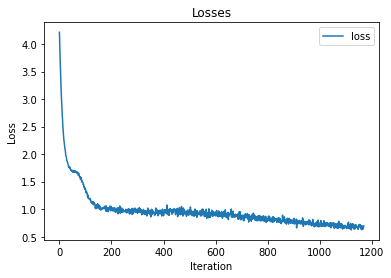

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [50]:
class BarlowTwins(nn.Module):
    def __init__(self, id_=1, od=128, lambda_=1e-2):
        super().__init__()
        self._lambda = lambda_

        self.encoder = ConvNet(id_, od)

        self.projector = nn.Sequential(
            nn.Linear(od, 2 * od),
            nn.BatchNorm1d(2 * od),
            nn.ReLU(True),
            nn.Linear(2 * od, od),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def _loss(self, x, y):
        x = self.projector(self.encoder(x))
        y = self.projector(self.encoder(y))

        x_norm = (x - x.mean(0)) / x.std(0)
        y_norm = (y - y.mean(0)) / y.std(0)
        
        N, D = x.size()

        cc = x_norm.T @ y_norm / N
        loss = (cc - torch.eye(D, device=self.device)).pow(2).mul_(self._lambda)
        loss[range(D), range(D)] /= self._lambda
        return loss.sum()

    def fit(self, train_dl, n_epochs=10, lr=5e-4, wd=0.):
        losses = []
        opt = optim.AdamW(self.parameters(), lr=lr, weight_decay=wd)
        with tqdm(total=n_epochs * len(train_dl)) as bar:
            for _ in range(n_epochs):
                for batch in train_dl:
                    x, y = batch
                    x, y = x.to(self.device), y.to(self.device)

                    loss = self._loss(x, y)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()

                    losses.append(loss.item())

                    bar.update(1)
                    bar.set_postfix(dict(loss=round(losses[-1], 5)))

        return np.array(losses)

    def forward(self, x):
        return self.encoder(x)


In [51]:
def q2(train_data, _):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

    contrast_transforms = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32),
        ]
    )
    dataset = SSDatasetWrapper(train_data, transform=contrast_transforms)
    train_dl = data.DataLoader(dataset, batch_size=256, drop_last=True, shuffle=True)

    barlow_twins = BarlowTwins(id_=3).to(DEVICE)

    losses = barlow_twins.fit(train_dl, n_epochs=20)
    barlow_twins.eval()

    @torch.no_grad()
    def _encode(x):
        return barlow_twins(x.to(barlow_twins.device)).cpu()

    return losses, _encode

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/3900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

mean classification accuracy=0.4400


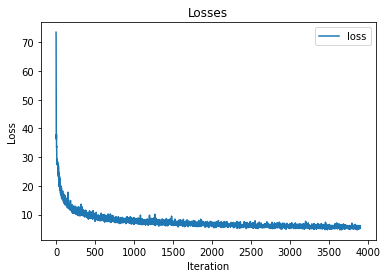

In [52]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


KeyboardInterrupt: 